In [166]:
# Copyright 2023 MosaicML Streaming authors
# SPDX-License-Identifier: Apache-2.0

"""compare loss from wandb runs with shuffle batch composition difference metric."""

import os.path
import sys

sys.path.append(os.path.join(os.path.abspath(''), '..'))

import numpy as np
from core.batch_composition_metrics import probability_l1_metric, probability_l2_metric, \
    probability_l1_metric_diffs, probability_l2_metric_diffs
import matplotlib.pyplot as plt
import pickle
from core.utils import exponential_weighted_moving_average, lr_schedule_cosine_warmup
from scipy.signal import savgol_filter
import pandas as pd

In [167]:
baseline_name = 'mpt-1b-py1e-NCN16-SBS1000000-random-1'
# Get the baseline train loss curve (strongest shuffle, smooth curve)
baseline_loss_file = open(f'./run_losses/train_loss_{baseline_name}', 'rb')
baseline_train_loss = pickle.load(baseline_loss_file)
smooth_baseline_train_loss = savgol_filter(baseline_train_loss, 50, 3)
baseline_loss_file.close()

In [170]:
experiment_names = [
    "mpt-1b-py1e-NCN1-SBS20000-random-1",
    "mpt-1b-py1e-NCN1-SBS100000-random-1",
    "mpt-1b-py1e-NCN1-SBS1000000-random-1",
    "mpt-1b-py1e-NCN4-SBS20000-random-1",
    "mpt-1b-py1e-NCN4-SBS100000-random-1",
    "mpt-1b-py1e-NCN4-SBS1000000-random-1",
    "mpt-1b-py1e-NCN6-SBS20000-random-1",
    "mpt-1b-py1e-NCN6-SBS100000-random-1",
    "mpt-1b-py1e-NCN6-SBS1000000-random-1",
    "mpt-1b-py1e-NCN16-SBS20000-random-1",
    "mpt-1b-py1e-NCN16-SBS100000-random-1",
    "mpt-1b-py1e-NCN16-SBS1000000-random-1",
    "mpt-1b-py1br-NCN1-SBS20000-random-1",
    "mpt-1b-py1br-NCN1-SBS100000-random-1",
    "mpt-1b-py1br-NCN1-SBS1000000-random-1",
    "mpt-1b-py1br-NCN4-SBS20000-random-1",
    "mpt-1b-py1br-NCN4-SBS100000-random-1",
    "mpt-1b-py1br-NCN4-SBS1000000-random-1",
    "mpt-1b-py1br-NCN6-SBS20000-random-1",
    "mpt-1b-py1br-NCN6-SBS100000-random-1",
    "mpt-1b-py1br-NCN6-SBS1000000-random-1",
    "mpt-1b-py1br-NCN16-SBS20000-random-1",
    "mpt-1b-py1br-NCN16-SBS100000-random-1",
    "mpt-1b-py1br-NCN16-SBS1000000-random-1",
    "mpt-1b-py1b-NCN1-SBS100000-random-1",
    "mpt-1b-py1b-NCN16-SBS1000000-random-1",
    "mpt-1b-py1e-NCN16-SBS1000000-stratified-1",
    "mpt-1b-py1s-NCN1-SBS20000-stratified-1",
]

In [171]:
experiment_data = {'name': [],
                   'train_loss': [],
                   'smooth_train_loss': [],
                   'loss_deviation': [],
                   'smooth_loss_deviation': [],
                   'ncn': [],
                   'sbs': [],
                   'shuffle_strength': [],
                   'last_train_loss': [],
                   'last_smooth_train_loss': [],
                   'mean_loss_deviation': [],
                   'std_loss_deviation': [],
                   'mean_smooth_loss_deviation': [],
                   'std_smooth_loss_deviation': [],
                   'batch_l1': [],
                   'batch_l2': [],
                   'batch_l1_mean': [],
                   'batch_l2_mean': [],
                   'batch_l1_std': [],
                   'batch_l2_std': [],}
cutoff_step = 9000
avg_samples_per_shard = 4596.447
for experiment_name in experiment_names:
    # get the train loss curve for this experiment
    experiment_file = open(f'./run_losses/train_loss_{experiment_name}', 'rb')
    experiment_train_loss = pickle.load(experiment_file)[:cutoff_step]
    smooth_experiment_train_loss = savgol_filter(experiment_train_loss, 50, 3)
    experiment_file.close()

    # get the batch composition probabilities for this experiment
    experiment_prob_file = open(f'./stream_batch_probabilities/probs_{experiment_name}', 'rb')
    experiment_probs = pickle.load(experiment_prob_file)
    experiment_prob_file.close()
    experiment_stream_probabilities = experiment_probs['stream_probabilities']
    experiment_batch_probabilities = experiment_probs['batch_probabilities']
    batch_composition_l1 = probability_l1_metric(experiment_stream_probabilities, experiment_batch_probabilities)
    batch_composition_l2 = probability_l2_metric(experiment_stream_probabilities, experiment_batch_probabilities)

    # get the NCN, SBS, and shuffle strength for this run
    name_info = experiment_name.split('-')
    ncn = int(name_info[3][3:])
    sbs = int(name_info[4][3:])
    shuffle_strength = ncn*sbs
    if 'py1s' in experiment_name or 'py2s' in experiment_name:
        shuffle_strength = ncn*avg_samples_per_shard

    experiment_data['name'].append(experiment_name)
    experiment_data['train_loss'].append(experiment_train_loss)
    experiment_data['smooth_train_loss'].append(smooth_experiment_train_loss)
    loss_deviation = experiment_train_loss - smooth_baseline_train_loss[:cutoff_step]
    smooth_loss_deviation = smooth_experiment_train_loss - smooth_baseline_train_loss[:cutoff_step]
    experiment_data['loss_deviation'].append(loss_deviation)
    experiment_data['smooth_loss_deviation'].append(smooth_loss_deviation)
    experiment_data['last_train_loss'].append(experiment_train_loss[-1])
    experiment_data['mean_loss_deviation'].append(np.mean(loss_deviation))
    experiment_data['std_loss_deviation'].append(np.std(loss_deviation))
    experiment_data['mean_smooth_loss_deviation'].append(np.mean(smooth_loss_deviation))
    experiment_data['std_smooth_loss_deviation'].append(np.std(smooth_loss_deviation))
    experiment_data['last_smooth_train_loss'].append(smooth_experiment_train_loss[-1])
    experiment_data['ncn'].append(ncn)
    experiment_data['sbs'].append(sbs)
    experiment_data['shuffle_strength'].append(shuffle_strength)
    experiment_data['batch_l1'].append(batch_composition_l1)
    experiment_data['batch_l2'].append(batch_composition_l2)
    experiment_data['batch_l1_mean'].append(np.mean(batch_composition_l1))
    experiment_data['batch_l2_mean'].append(np.mean(batch_composition_l2))
    experiment_data['batch_l1_std'].append(np.std(batch_composition_l1))
    experiment_data['batch_l2_std'].append(np.std(batch_composition_l2))

In [172]:
full_experiment_data = {'name': [],
                   'train_loss': [],
                   'smooth_train_loss': [],
                   'loss_deviation': [],
                   'smooth_loss_deviation': [],
                   'ncn': [],
                   'sbs': [],
                   'shuffle_strength': [],
                   'last_train_loss': [],
                   'last_smooth_train_loss': [],
                   'mean_loss_deviation': [],
                   'std_loss_deviation': [],
                   'mean_smooth_loss_deviation': [],
                   'std_smooth_loss_deviation': [],
                   'batch_l1': [],
                   'batch_l2': [],
                   'batch_l1_mean': [],
                   'batch_l2_mean': [],
                   'batch_l1_std': [],
                   'batch_l2_std': [],}
for experiment_name in experiment_names:
    # get the train loss curve for this experiment
    experiment_file = open(f'./run_losses/train_loss_{experiment_name}', 'rb')
    experiment_train_loss = pickle.load(experiment_file)
    smooth_experiment_train_loss = savgol_filter(experiment_train_loss, 50, 3)
    experiment_file.close()

    # get the batch composition probabilities for this experiment
    experiment_prob_file = open(f'./stream_batch_probabilities/probs_{experiment_name}', 'rb')
    experiment_probs = pickle.load(experiment_prob_file)
    experiment_prob_file.close()
    experiment_stream_probabilities = experiment_probs['stream_probabilities']
    experiment_batch_probabilities = experiment_probs['batch_probabilities']
    batch_composition_l1 = probability_l1_metric(experiment_stream_probabilities, experiment_batch_probabilities)
    batch_composition_l2 = probability_l2_metric(experiment_stream_probabilities, experiment_batch_probabilities)

    # get the NCN, SBS, and shuffle strength for this run
    name_info = experiment_name.split('-')
    ncn = int(name_info[3][3:])
    sbs = int(name_info[4][3:])
    shuffle_strength = ncn*sbs
    if 'py1s' in experiment_name or 'py2s' in experiment_name:
        shuffle_strength = ncn*avg_samples_per_shard

    full_experiment_data['name'].append(experiment_name)
    full_experiment_data['train_loss'].append(experiment_train_loss)
    full_experiment_data['smooth_train_loss'].append(smooth_experiment_train_loss)
    loss_deviation = experiment_train_loss - smooth_baseline_train_loss[:len(experiment_train_loss)]
    smooth_loss_deviation = smooth_experiment_train_loss - smooth_baseline_train_loss[:len(smooth_experiment_train_loss)]
    full_experiment_data['loss_deviation'].append(loss_deviation)
    full_experiment_data['smooth_loss_deviation'].append(smooth_loss_deviation)
    full_experiment_data['last_train_loss'].append(experiment_train_loss[-1])
    full_experiment_data['mean_loss_deviation'].append(np.mean(loss_deviation))
    full_experiment_data['std_loss_deviation'].append(np.std(loss_deviation))
    full_experiment_data['mean_smooth_loss_deviation'].append(np.mean(smooth_loss_deviation))
    full_experiment_data['std_smooth_loss_deviation'].append(np.std(smooth_loss_deviation))
    full_experiment_data['last_smooth_train_loss'].append(smooth_experiment_train_loss[-1])
    full_experiment_data['ncn'].append(ncn)
    full_experiment_data['sbs'].append(sbs)
    full_experiment_data['shuffle_strength'].append(shuffle_strength)
    full_experiment_data['batch_l1'].append(batch_composition_l1)
    full_experiment_data['batch_l2'].append(batch_composition_l2)
    full_experiment_data['batch_l1_mean'].append(np.mean(batch_composition_l1))
    full_experiment_data['batch_l2_mean'].append(np.mean(batch_composition_l2))
    full_experiment_data['batch_l1_std'].append(np.std(batch_composition_l1))
    full_experiment_data['batch_l2_std'].append(np.std(batch_composition_l2))

In [173]:
# create dataframe with this data
experiment_df = pd.DataFrame.from_dict(experiment_data)
full_experiment_df = pd.DataFrame.from_dict(full_experiment_data)

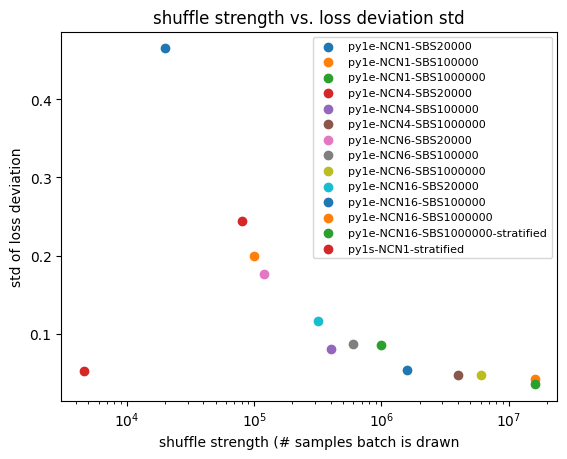

In [230]:
for i, name in enumerate(experiment_df['name']):
    if 'py1e' in name or 'py1s' in name:
        name_info = name.split('-')
        label = 'py1e-' + name_info[3] + '-' + name_info[4]
        if 'stratified' in name:
            label += '-stratified'
        if 'py1s' in name:
            label = 'py1s-' + name_info[3] + '-stratified'
        plt.scatter(experiment_df['shuffle_strength'][i], experiment_df['std_loss_deviation'][i], label=label)
plt.xscale('log')
plt.xlabel('shuffle strength (# samples batch is drawn from)')
plt.ylabel('std of loss deviation')
plt.title('shuffle strength vs. loss deviation std')
plt.legend(fontsize="8")

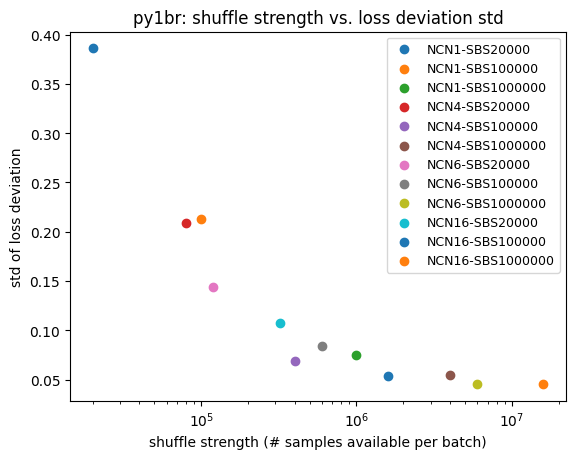

In [208]:
for i, name in enumerate(experiment_df['name']):
    if 'py1br' in name:
        name_info = name.split('-')
        plt.scatter(experiment_df['shuffle_strength'][i], experiment_df['std_loss_deviation'][i], label=name_info[3]+'-'+name_info[4])
plt.xscale('log')
plt.xlabel('shuffle strength (# samples available per batch)')
plt.ylabel('std of loss deviation')
plt.title('py1br: shuffle strength vs. loss deviation std')
plt.legend(fontsize="9")

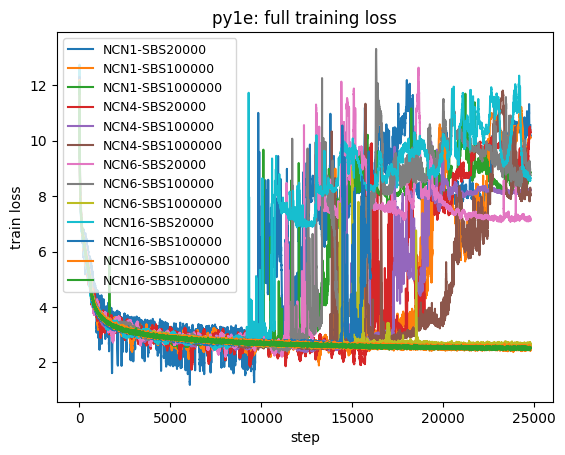

In [210]:
for i, name in enumerate(full_experiment_df['name']):
    if 'py1e' in name:
        name_info = name.split('-')
        plt.plot(np.arange(len(full_experiment_df['train_loss'][i])), full_experiment_df['train_loss'][i], label=name_info[3]+'-'+name_info[4])
plt.xlabel('step')
plt.ylabel('train loss')
plt.title('py1e: full training loss')
plt.legend(fontsize="9")

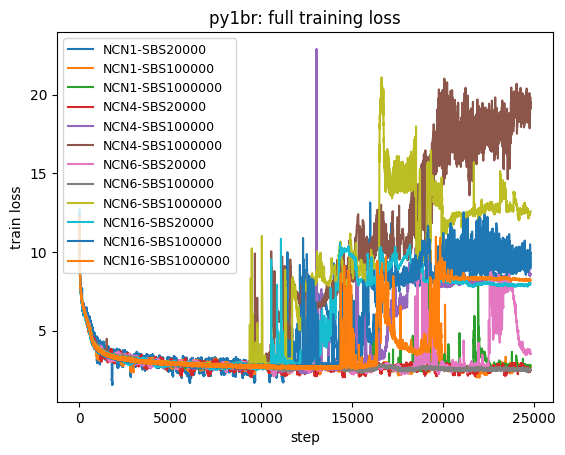

In [213]:
for i, name in enumerate(full_experiment_df['name']):
    if 'py1br' in name:
        name_info = name.split('-')
        plt.plot(np.arange(len(full_experiment_df['train_loss'][i])), full_experiment_df['train_loss'][i], label=name_info[3]+'-'+name_info[4])
plt.xlabel('step')
plt.ylabel('train loss')
plt.title('py1br: full training loss')
plt.legend(fontsize="9")

In [179]:
strongest_shuffles = [
    "mpt-1b-py1br-NCN16-SBS1000000-random-1",
    "mpt-1b-py1b-NCN16-SBS1000000-random-1",
    "mpt-1b-py1e-NCN16-SBS1000000-random-1",
    "mpt-1b-py1e-NCN16-SBS1000000-stratified-1",
]

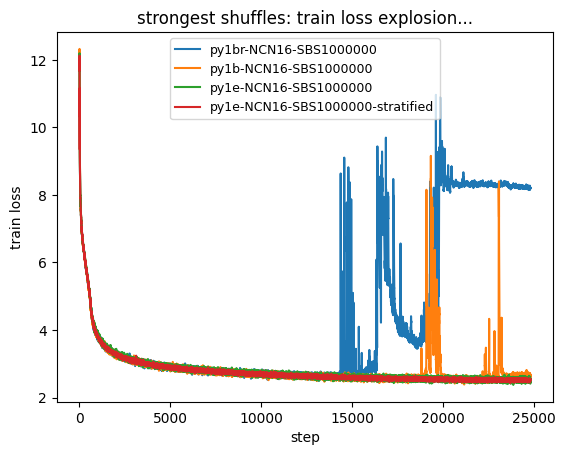

In [214]:
for name in strongest_shuffles:
    name_info = name.split('-')
    label = name_info[2] + '-' + name_info[3] + '-' + name_info[4]
    if 'stratified' in name:
        label += '-stratified'
    row = full_experiment_df.loc[full_experiment_df['name'] == name]
    train_loss = row.iloc[0]['train_loss']
    steps = len(train_loss)
    plt.plot(np.arange(steps), train_loss, label=label)
plt.xlabel('step')
plt.ylabel('train loss')
plt.title('strongest shuffles: train loss explosion...')
plt.legend(fontsize="9")

In [181]:
no_explosion_shuffles = [
    "mpt-1b-py1e-NCN6-SBS1000000-random-1",
    "mpt-1b-py1e-NCN16-SBS1000000-random-1",
    "mpt-1b-py1e-NCN16-SBS1000000-stratified-1",
    "mpt-1b-py1br-NCN1-SBS100000-random-1",
    "mpt-1b-py1br-NCN4-SBS20000-random-1",
    "mpt-1b-py1br-NCN6-SBS100000-random-1",
    "mpt-1b-py1s-NCN1-SBS20000-stratified-1",
]

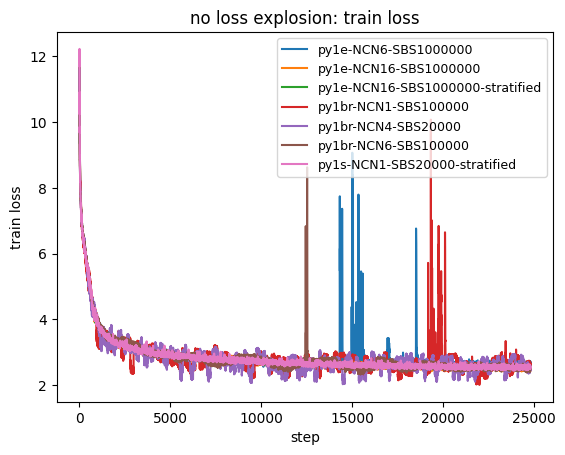

In [215]:
for name in no_explosion_shuffles:
    name_info = name.split('-')
    label = name_info[2] + '-' + name_info[3] + '-' + name_info[4]
    if 'stratified' in name:
        label += '-stratified'
    row = full_experiment_df.loc[full_experiment_df['name'] == name]
    train_loss = row.iloc[0]['train_loss']
    steps = len(train_loss)
    plt.plot(np.arange(steps), train_loss, label=label)
plt.xlabel('step')
plt.ylabel('train loss')
plt.title('no loss explosion: train loss')
plt.legend(fontsize="9")

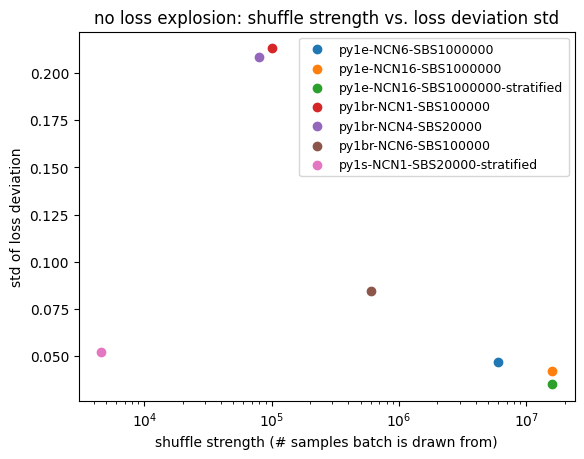

In [216]:
for name in no_explosion_shuffles:
    name_info = name.split('-')
    label = name_info[2] + '-' + name_info[3] + '-' + name_info[4]
    if 'stratified' in name:
        label += '-stratified'
    row = experiment_df.loc[experiment_df['name'] == name]
    plt.scatter(row.iloc[0]['shuffle_strength'], row.iloc[0]['std_loss_deviation'], label=label)
plt.xscale('log')
plt.xlabel('shuffle strength (# samples batch is drawn from)')
plt.ylabel('std of loss deviation')
plt.title('no loss explosion: shuffle strength vs. loss deviation std')
plt.legend(fontsize="9")

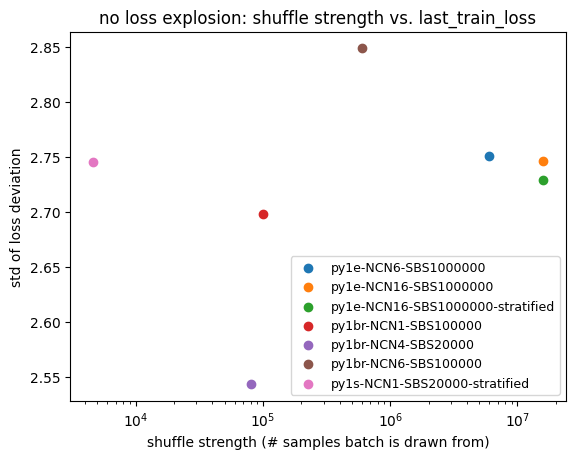

In [202]:
# lol use actual eval results for this.
for name in no_explosion_shuffles:
    name_info = name.split('-')
    label = name_info[2] + '-' + name_info[3] + '-' + name_info[4]
    if 'stratified' in name:
        label += '-stratified'
    row = experiment_df.loc[experiment_df['name'] == name]
    plt.scatter(row.iloc[0]['shuffle_strength'], row.iloc[0]['last_smooth_train_loss'], label=label)
plt.xscale('log')
plt.xlabel('shuffle strength (# samples batch is drawn from)')
plt.ylabel('std of loss deviation')
plt.title('no loss explosion: shuffle strength vs. last_train_loss')
plt.legend(fontsize="9")

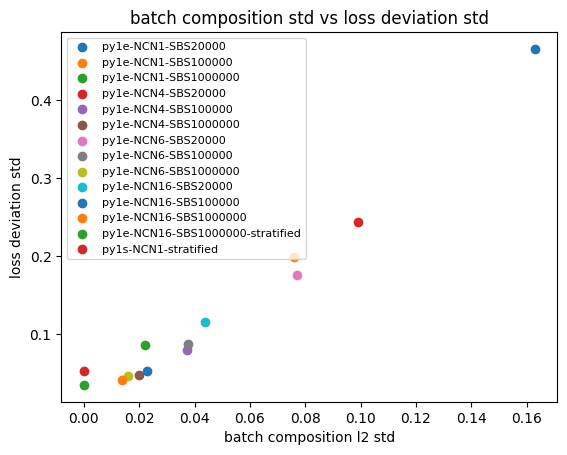

In [228]:
for i, name in enumerate(experiment_df['name']):
    if 'py1e' in name or 'py1s' in name:
        name_info = name.split('-')
        label = 'py1e-' + name_info[3] + '-' + name_info[4]
        if 'stratified' in name:
            label += '-stratified'
        if 'py1s' in name:
            label = 'py1s-' + name_info[3] + '-stratified'
        plt.scatter(experiment_df['batch_l2_std'][i], experiment_df['std_loss_deviation'][i], label=label)
plt.xlabel('batch composition l2 std')
plt.ylabel('loss deviation std')
plt.title('batch composition std vs loss deviation std')
plt.legend(fontsize="8")

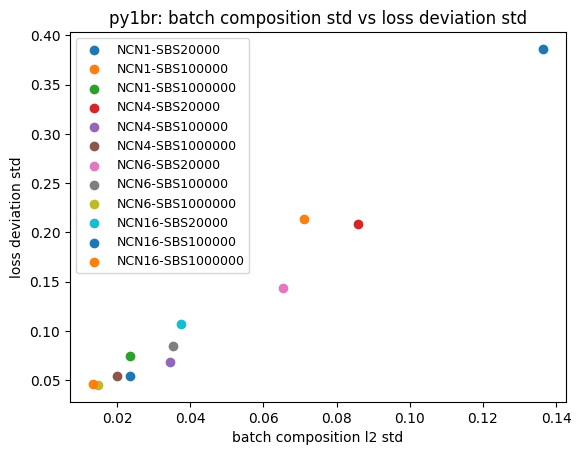

In [203]:
for i, name in enumerate(experiment_df['name']):
    if 'py1br' in name:
        name_info = name.split('-')
        label = name_info[3] + '-' + name_info[4]
        if 'stratified' in name:
            label += '-stratified'
        plt.scatter(experiment_df['batch_l2_std'][i], experiment_df['std_loss_deviation'][i], label=label)
plt.xlabel('batch composition l2 std')
plt.ylabel('loss deviation std')
plt.title('py1br: batch composition std vs loss deviation std')
plt.legend(fontsize="9")

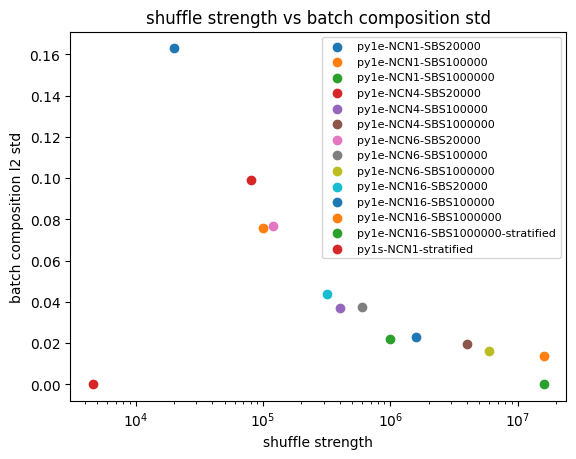

In [226]:
for i, name in enumerate(experiment_df['name']):
    if 'py1e' in name or 'py1s' in name:
        name_info = name.split('-')
        label = 'py1e-' + name_info[3] + '-' + name_info[4]
        if 'stratified' in name:
            label += '-stratified'
        if 'py1s' in name:
            label = 'py1s-' + name_info[3] + '-stratified'
        plt.scatter(experiment_df['shuffle_strength'][i], experiment_df['batch_l2_std'][i], label=label)
plt.xscale('log')
plt.xlabel('shuffle strength')
plt.ylabel('batch composition l2 std')
plt.title('shuffle strength vs batch composition std')
plt.legend(fontsize="8")

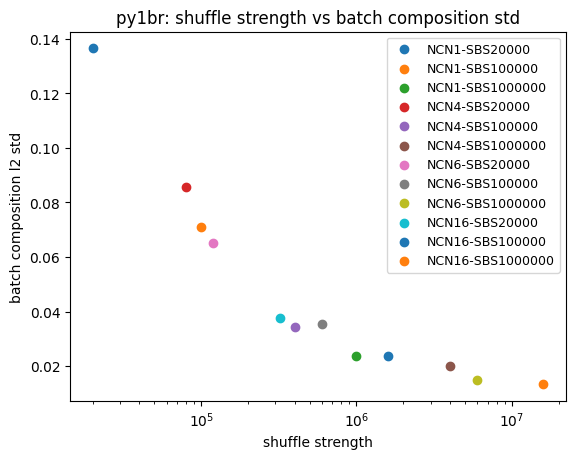

In [220]:
for i, name in enumerate(experiment_df['name']):
    if 'py1br' in name:
        name_info = name.split('-')
        label = name_info[3] + '-' + name_info[4]
        if 'stratified' in name:
            label += '-stratified'
        plt.scatter(experiment_df['shuffle_strength'][i], experiment_df['batch_l2_std'][i], label=label)
plt.xscale('log')
plt.xlabel('shuffle strength')
plt.ylabel('batch composition l2 std')
plt.title('py1br: shuffle strength vs batch composition std')
plt.legend(fontsize="9")